# Курсовой проект 
## для курса "Python для Data Science"

#### Задание:
***Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).***


*Требования к курсовому:*  
*Нужно будет оформить ноутбук с основными этапами:*

1. подготовка данных
        анализ
        визуализация
        обработка выбросов
        обработка пропусков
        генерация фичей
2. обучение модели
3. проверка качества модели

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

 
\begin{equation*}
R^2 = 1 − \frac{σ^2}{σ^2_y}
\end{equation*}

### 1. Подключение библиотек и скриптов

In [1128]:
import numpy as np
import pandas as pd
import datetime
import pickle
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from scipy import stats 
from scipy.stats import mode

from IPython.display import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [1129]:
matplotlib.rcParams.update({'font.size': 14}) 

Пути к директориям и файлам

In [1130]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './test.csv'

data = pd.read_csv(DATASET_PATH)
X_test = pd.read_csv(PREPARED_DATASET_PATH)

RESULT_PATH = './ViacheslavS_predictions.csv'

### 2. Загрузка данных и анализ датасета

**Описания полей датасета по недвижимости**  

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры.

Считываем данные. По строкам - наблюдения, по столбцам - признаки.

In [1131]:
df = data.copy()

In [1132]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.sample(frac=1)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4339,26,20,2.0,54.904566,32.999142,8.0,15,23.0,2010,0.019509,B,B,37,7687,11,176.0,5,5,B,391080.562804
928,14575,67,2.0,46.350558,31.191642,6.0,6,9.0,1974,0.100456,B,B,43,7227,0,NaN,1,6,A,214473.371739
244,13137,23,1.0,43.790432,NaN,0.0,10,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,121517.604121
6470,10843,46,3.0,64.009908,48.683664,6.0,6,9.0,1972,0.188784,B,B,31,6137,4,NaN,0,1,B,268580.120772
8233,1714,104,3.0,66.679435,42.359884,8.0,9,7.0,1937,0.327018,B,B,12,2270,23,2500.0,1,0,B,421756.290145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,15132,96,2.0,55.111052,34.926757,9.0,11,16.0,2001,0.041116,B,B,53,14892,4,NaN,1,4,B,238400.861711
1161,16126,42,1.0,41.986207,20.566409,7.0,17,17.0,2008,0.158249,B,B,21,5731,0,NaN,1,0,B,164137.151505
519,10004,45,2.0,78.230578,NaN,1.0,15,22.0,2018,0.195781,B,B,23,5212,6,NaN,3,2,B,372016.922629
6068,4189,93,3.0,62.577102,45.215659,6.0,1,12.0,1975,0.521867,B,B,25,6149,0,NaN,0,0,B,186861.181662


In [1133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В тренировочном датасете 10000 строк и 20 столбцов.

Нечисловые признаки: Ecology_2, Ecology_3, Shops_2.  
DistrictId и Id нужно отнести к категориальным признакам.

Признаки  LifeSquare и Healthcare_1  имеют пропуски.  
Необходимо будет посчитать их и принять решение, каким образом их обрабатывать.

In [1134]:
# Сразу меняем тип данных
df['Id'] = df['Id'].astype(object)
df['DistrictId'] = df['DistrictId'].astype(object)
df['Rooms'] = df['Rooms'].astype(int)
df['HouseFloor'] = df['HouseFloor'].astype(int)

In [1135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  int32  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

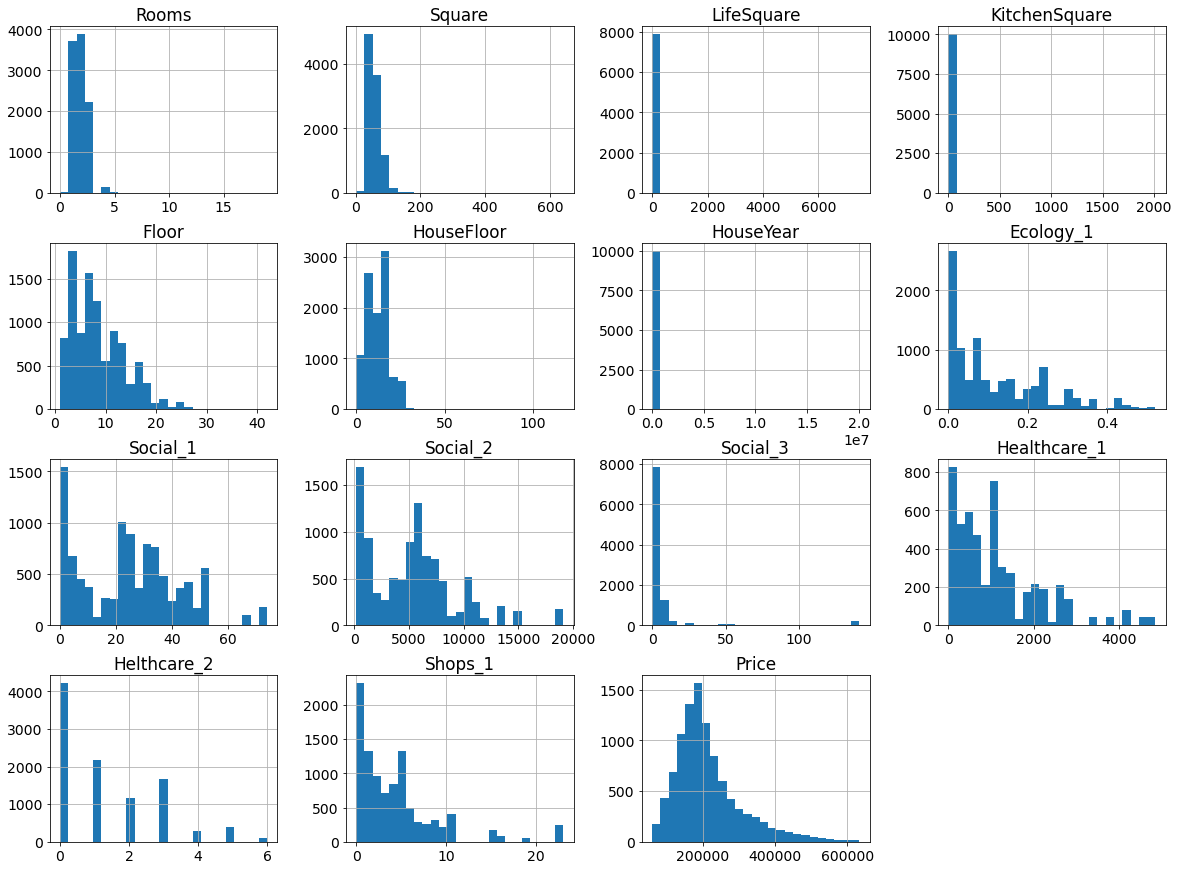

In [1136]:
# Оценим числовые признаки:
digital_features=df.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(20,15), bins=25)
plt.show()

Имеет смысл почистить выбросы по количеству комнат, в площадях, в годах постройки дома.  
Helthcare_2 относится к категориальным признакам.
Показатели местности Social и Shops интерпретировать трудно.

In [1137]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Заключения по показателям признаков подтверждаются.

Для недвижимости одним из главных признаков является стоимость за квадратный метр. Введем данный признак в датасет.

In [1138]:
df.insert(2,'SqMeterPrice', df.Price/df.Square)

In [1139]:
df.describe()

,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,3988.383777,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,3755.437224,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,208.293451,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,2918.525328,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,3910.052336,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,4692.375993,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,230463.537966,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Всё, что дороже 10.000 долл/кв.м и менее 1000 долл/кв.м будем считать выбросами и приравняем их к медиане, а до 10.000 допускаем цену на элитное жилье.

In [1140]:
df.loc[(df['SqMeterPrice'] < 1000) | (df['SqMeterPrice'] > 10000), 'SqMeterPrice'] = df['SqMeterPrice'].median()

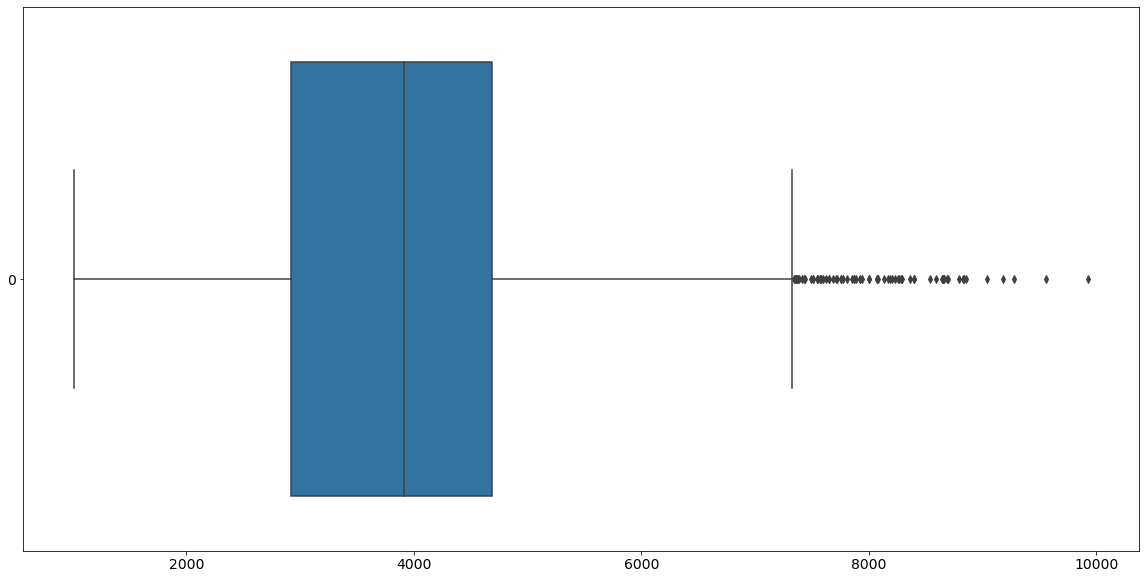

In [1141]:
# Оценим выбросы:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df.SqMeterPrice, orient='h')
plt.show()

Значимым фактором стоимости недвижимости является также площать жилья.

In [1142]:
df.sort_values(by='Square', axis=0, ascending=True).sample(frac=1)

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5088,9225,59,4736.631611,2,56.620746,30.445960,11.0,16,16,1981,...,B,B,35,7715,4,990.0,0,6,B,268191.615127
5179,5617,25,4216.650001,3,109.559904,56.927818,13.0,4,25,2009,...,B,B,53,13670,4,NaN,1,11,B,461975.770576
4521,5634,52,2647.307298,1,43.095135,NaN,1.0,10,17,1977,...,B,B,34,7065,1,750.0,2,5,B,114086.065201
3386,5395,27,2982.649954,1,46.376306,23.533797,8.0,14,14,2011,...,B,B,53,14892,4,NaN,1,4,B,138324.287347
30,89,50,7198.556910,2,39.435351,23.377687,7.0,9,9,1965,...,B,B,35,7077,56,2301.0,3,19,B,283877.617142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9852,16641,111,1685.920195,4,117.201937,69.898092,14.0,4,2,2017,...,B,B,23,4635,5,3300.0,2,4,B,197593.112769
8569,14093,25,4071.278459,2,83.000038,78.935165,1.0,5,23,2013,...,B,B,53,13670,4,NaN,1,11,B,337916.265384
1672,12213,1,3072.478224,2,65.406975,64.189338,10.0,16,17,1977,...,B,B,1,264,0,NaN,0,1,B,200961.505005
349,11866,28,3185.458226,2,47.918192,30.138243,5.0,5,5,1977,...,B,B,30,6207,1,1183.0,1,0,B,152641.398777


Нужно избавится от слишком маленьких помещений (менее 5 кв.м) и квартир с огромной площадью (более 300 кв.м)

In [1143]:
df.loc[(df.Square<20), 'Square']= df['Square'].median()
df.loc[(df.Square>1000), 'Square']= df['Square'].median()

Также нужно избавится от слишком маленьких жилых помещений (менее 5 кв.м) и слишком больших (более 300 кв.м)

In [1144]:
df.loc[(df.LifeSquare<5), 'LifeSquare']= df['LifeSquare'].median()
df.loc[(df.LifeSquare>300), 'LifeSquare']= df['LifeSquare'].median()

Оценим корреляцию признаков в датасете:

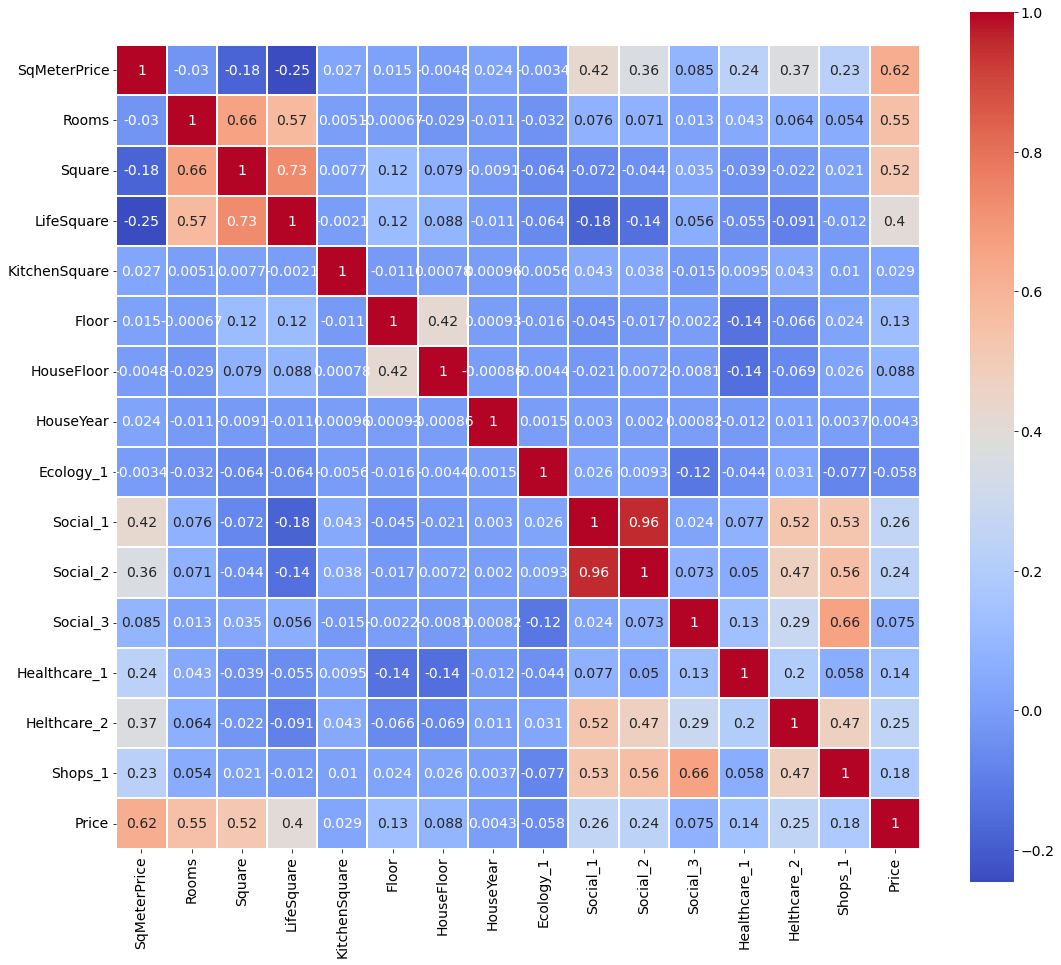

In [1145]:
df_corr=df.corr()
plt.figure(figsize=(18,16))
sns.heatmap(df_corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.show()

Целевая переменная Price сильно зависит от цены за кв.м, площади и количества комнат. Проверим и откоректируем показатель количества комнат.

In [1146]:
df.Rooms.unique()

array([ 2,  3,  1,  4, 10,  0,  5, 19,  6])

Такие показатели, как 0, 10 и 19 считаем ложными и заменим их на наиболеее частые значения количества комнат.

In [1147]:
df.loc[(df.Rooms>6)|(df.Rooms==0)]

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,5372.190561,10,59.056975,36.223072,10.0,22,22,2002,...,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,1938.880408,0,138.427694,136.215499,0.0,4,3,2016,...,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,1865.555669,19,42.006046,21.779288,7.0,17,17,2014,...,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,1419.282909,0,212.932361,211.231125,0.0,2,3,2008,...,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,2348.119347,0,41.790881,NaN,0.0,13,0,1977,...,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,4385.488771,0,49.483501,NaN,0.0,16,0,2015,...,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,2612.112170,0,81.491446,NaN,0.0,4,0,1977,...,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,3910.052336,0,52.513310,32.781260,0.0,1,0,1977,...,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,4108.784399,0,38.697117,19.345131,9.0,9,16,1982,...,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,2498.580012,0,87.762616,85.125471,0.0,5,15,1977,...,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [1148]:
df.loc[((df.Rooms>6)|(df.Rooms==0)), 'Rooms'] = df['Rooms'].median()

In [1149]:
# Проверим, какие значения комнат теперь остались:
df.Rooms.unique()

array([2, 3, 1, 4, 5, 6])

In [1150]:
# Посмотрим на пропуски в данных:
df.isna().sum()

Id                  0
DistrictId          0
SqMeterPrice        0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Пропуски в столбцах "LifeSquare" и "Healthcare_1" лучше убрать, используя метод 'pad'. Для этого необходимо предварительно отсортировать данные по столбцу с этим параметром.

Площадь кухни и этажность учитывать не будем.

In [1151]:
df=df.sort_values(by='LifeSquare')
df.LifeSquare.fillna(method='pad',inplace=True)

In [1152]:
df=df.sort_values(by='Healthcare_1')
df.Healthcare_1.fillna(method='pad',inplace=True)

In [1153]:
df.sort_index(inplace=True)

In [1154]:
df.sample(10)

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6941,10535,27,2212.846109,1,40.250474,41.416099,0.0,1,0,1977,...,B,B,4,915,0,4849.0,0,0,B,89068.104959
4861,2282,74,4353.967079,2,55.449752,30.584191,9.0,2,23,2010,...,B,B,34,7065,1,750.0,2,5,B,241426.396100
5261,16413,52,2701.174903,1,42.621442,263.542020,1.0,11,17,1977,...,B,B,34,7065,1,750.0,2,5,B,115127.969838
2384,11949,193,3646.873189,1,35.784271,20.656814,5.0,1,5,1969,...,B,B,25,4756,16,2857.0,5,8,B,130500.697853
6785,12975,67,4157.541383,3,77.668432,49.074675,10.0,9,16,1978,...,B,B,38,4788,2,4849.0,0,4,B,322909.720956
4384,16560,1,3795.412740,1,45.203472,263.542020,1.0,5,9,2015,...,B,B,1,264,0,4849.0,0,1,B,171565.833888
6688,2758,11,4424.986138,1,44.163977,21.116011,12.0,14,4,1977,...,B,B,28,6533,1,1015.0,2,5,B,195424.986679
9335,6657,27,3025.972483,2,61.041134,62.816836,10.0,7,22,2016,...,B,B,2,629,1,4849.0,0,0,A,184708.791256
1887,9614,142,5420.570184,2,47.326213,29.785644,5.0,5,9,1973,...,B,B,17,4017,7,800.0,2,0,B,256535.057100
5199,5414,21,4423.876189,1,40.216579,20.879048,9.0,4,14,1996,...,B,B,25,5487,3,4849.0,0,4,B,177913.165131


In [1155]:
df.describe()

,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,3886.927113,1.888800,56.406029,84.623417,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,2921.08910,1.319500,4.231300,214138.857399
std,1228.447127,0.812096,20.947462,93.888239,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1992.81252,1.493601,4.806341,92872.293865
min,1009.937996,1.000000,20.213128,5.005477,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,59174.778028
25%,2922.202348,1.000000,41.811910,27.374900,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.00000,0.000000,1.000000,153872.633942
50%,3910.052336,2.000000,52.513580,38.311844,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,3855.00000,1.000000,3.000000,192269.644879
75%,4688.990333,2.000000,65.900625,68.531147,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,4849.00000,2.000000,6.000000,249135.462171
max,9930.586635,6.000000,641.065193,263.542020,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,633233.466570


In [1156]:
df.isna().sum()

Id               0
DistrictId       0
SqMeterPrice     0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

***Пропуски и выбросы обработаны, данные приведены к удобному формату***

### 3. Подготовка данных:

Создадим класс FeaturesGenerator для подготовки данных для модели

In [1157]:
class FeaturesGenerator():
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        self.current_year=None
        self.cat_columns=None
        self.rsqm=None
        self.nsqm=None
        
        
    def fit(self,df):
        """Сохранение статистик"""
        
        # Определяем текущий год для вычисления возраста дома
        self.current_year=datetime.datetime.now().year
        
        # Корректируем значения площади и количества комнат
        df.loc[(df.Square<20), 'Square']= df['Square'].median()
        df.loc[(df.Square>1000), 'Square']= df['Square'].median()
        
        df.loc[(df.LifeSquare<5), 'LifeSquare']= df['LifeSquare'].median()
        df.loc[(df.LifeSquare>300), 'LifeSquare']= df['LifeSquare'].median()
        
        df.loc[((df.Rooms>6)|(df.Rooms==0)), 'Rooms'] = df['Rooms'].median()
        
        # Добавляем стоимость кв.м для последующей агрегации данных
        df.insert(1, 'SqMeterPrice',df['Price']/df['Square'])
        
        # Вычисляем среднюю стоимость кв.м в зависимости от числа комнат 
        # и среднюю стоимость кв.м в зависимости от района и количества комнат
        self.rsqm=df.groupby(by=['Rooms'])['SqMeterPrice'].mean().rename('RoomSqMeterPrice', inplace=True)
        self.nsqm=df.groupby(by=['DistrictId','Rooms'])['SqMeterPrice'].mean().rename('DistSqMeterPrice', inplace=True) 
        
        # Заменяем слишком высокие и слишком низкие цены за кв.м. на медианные
        df.loc[(df['SqMeterPrice'] < 1000) | (df['SqMeterPrice'] > 10000), 'SqMeterPrice'] = df['SqMeterPrice'].median()
                
        # Удаляем лишнее
        df.drop('SqMeterPrice', axis=1, inplace=True)
        
        # Назначаем столбцы для последующего дамми-кодирования
        self.cat_columns=df.select_dtypes('object').columns
        
        
    def transform(self, df):
        """Трансформация данных"""
        # Заменяем год постройки дома на возраст дома(выбросы по году постройки предварительно исправляем на текущий год)
        
        df.loc[(df.HouseYear>self.current_year),'HouseYear']=self.current_year-1
        df.insert(df.columns.get_loc('HouseYear'), 'HousAge', self.current_year - df['HouseYear'])
        df.drop('HouseYear', axis=1, inplace=True)
       
        # Кодируем категориальные переменные
        
        df=pd.get_dummies(df, columns=self.cat_columns)
        
        # Корректируем значения площадей в тестовом датасете
        
        df.loc[(df.Square<5), 'Square']= df['Square'].median()
        df.loc[(df.Square>300), 'Square']= df['Square'].median()
        
        # Корректируем количество комнат в тестовом датасете
        
        df.loc[((df.Rooms>6)|(df.Rooms==0)), 'Rooms'] = df['Rooms'].median()
                
        # Обрабатываем пропуски полях Healthcare_1 и LifeSquare, заполняя их методом 'pad'
        
        df=df.sort_values(by='LifeSquare')
        df.LifeSquare.fillna(method='pad',inplace=True)
        
        df=df.sort_values(by='Healthcare_1')
        df.Healthcare_1.fillna(method='pad',inplace=True)
        
        df.sort_index(inplace=True)
            
        # Добавляем поле DistSqMeterPrice - средняя стоимость кв.м в зависимости от района и количества комнат
        
        df=df.merge(self.rsqm, how='left', on='Rooms')
        df=df.merge(self.nsqm, how='left', on=['DistrictId', 'Rooms'])
        df.insert(1, 'DistSqMeterPrice', df.pop('DistSqMeterPrice'))
        
        # Заменяем пропуски, которые получились из-за того, что в тесте и трейне есть несовпадающие по Id районы,
        # на среднюю стоимость кв.м в зависимости от площади
        
        df.DistSqMeterPrice.fillna(df.RoomSqMeterPrice, inplace=True)
        
        # Удаляем лишнее
        
        df.drop('RoomSqMeterPrice', axis=1, inplace=True)
        
        # Переводим DistrictId, и Id в нечисловые признаки
        
        df['DistrictId']=df['DistrictId'].astype('object')
        df['Id']=df['Id'].astype('object')
        
        return df

Преобразуем данные:

In [1158]:
generator=FeaturesGenerator()
generator.fit(data)
DF=generator.transform(data)
X_test=generator.transform(X_test)

In [1159]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                10000 non-null  object 
 1   DistSqMeterPrice  10000 non-null  float64
 2   DistrictId        10000 non-null  object 
 3   Rooms             10000 non-null  float64
 4   Square            10000 non-null  float64
 5   LifeSquare        10000 non-null  float64
 6   KitchenSquare     10000 non-null  float64
 7   Floor             10000 non-null  int64  
 8   HouseFloor        10000 non-null  float64
 9   HousAge           10000 non-null  int64  
 10  Ecology_1         10000 non-null  float64
 11  Social_1          10000 non-null  int64  
 12  Social_2          10000 non-null  int64  
 13  Social_3          10000 non-null  int64  
 14  Healthcare_1      10000 non-null  float64
 15  Helthcare_2       10000 non-null  int64  
 16  Shops_1           10000 non-null  int64  

In [1160]:
DF.sample(10, random_state=125)

,Id,DistSqMeterPrice,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HousAge,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
79,12162,5603.108392,69,1.0,39.252555,19.394251,7.0,1,16.0,37,...,4849.0,1,9,184737.921069,0,1,0,1,0,1
2348,9573,2402.349616,23,1.0,44.107565,263.542020,1.0,6,25.0,45,...,4849.0,0,2,158818.815571,0,1,0,1,0,1
6680,11930,4069.192208,47,3.0,67.802432,37.064571,8.0,14,17.0,43,...,4849.0,3,3,298920.800769,0,1,0,1,0,1
7997,8595,5454.055057,143,2.0,47.670611,31.707301,5.0,4,5.0,60,...,75.0,3,1,210517.654122,0,1,0,1,0,1
1150,16421,2402.349616,23,1.0,41.857859,263.542020,1.0,5,17.0,45,...,4849.0,0,2,132219.729217,0,1,0,1,0,1
7361,7688,3939.838753,22,1.0,41.152322,22.923518,8.0,3,14.0,22,...,1183.0,1,0,183888.860247,0,1,0,1,0,1
785,3290,2828.177040,6,2.0,64.416586,263.542020,1.0,12,1.0,45,...,540.0,0,0,176682.487067,0,1,0,1,0,1
9325,11092,4267.928228,29,1.0,31.359350,18.146328,5.0,4,5.0,62,...,4849.0,1,2,154987.850604,0,1,0,1,0,1
7022,10247,3861.512114,99,2.0,55.293756,31.264869,9.0,12,12.0,49,...,1322.0,3,8,189823.998652,0,1,0,1,0,1
8931,14132,2884.577199,27,1.0,34.758250,17.130385,10.0,17,25.0,9,...,4849.0,0,0,105394.761734,0,1,0,1,1,0


In [1161]:
df.describe()

,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,3886.927113,1.888800,56.406029,84.623417,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,2921.08910,1.319500,4.231300,214138.857399
std,1228.447127,0.812096,20.947462,93.888239,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1992.81252,1.493601,4.806341,92872.293865
min,1009.937996,1.000000,20.213128,5.005477,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,59174.778028
25%,2922.202348,1.000000,41.811910,27.374900,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.00000,0.000000,1.000000,153872.633942
50%,3910.052336,2.000000,52.513580,38.311844,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,3855.00000,1.000000,3.000000,192269.644879
75%,4688.990333,2.000000,65.900625,68.531147,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,4849.00000,2.000000,6.000000,249135.462171
max,9930.586635,6.000000,641.065193,263.542020,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,633233.466570


In [1162]:
DF.shape, X_test.shape

((10000, 24), (5000, 23))

In [1163]:
# Уменьшим объем памяти, который занимает датасет

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1164]:
DF = reduce_mem_usage(DF)

Memory usage of dataframe is 1.51 MB
Memory usage after optimization is: 1.11 MB
Decreased by 26.3%


### 4. Выбор и обучение модели

Лучшая модель - модель с наименьшей MSE на test.

Были рассмотрены Random Forest, GradientBoostingRegressor и Gradient Boosting decision trees.

В качестве модели для предсказания цены выбрана **GradientBoostingRegressor** из библиотеки sklearn. Эта модель хорошо справляется с немасштабированым данными, устойчива к переобучению, находит сложные зависимости в признаках.  
Параметры модели подобраны при помощи GridSearchCV.

Для начала отделяем целевую переменную Price, так же удалим неинформативный столбец Id.

In [1165]:
y_train=DF.Price
X_train=DF.drop(['Id', 'Price'], axis=1)
# Столбец 'Id' из тестовых данных сохраним, он будет нужен для файла с результатом при совмещении данных
test_idx=X_test.pop('Id')

In [1166]:
X_train.shape, X_test.shape, y_train.shape

((10000, 22), (5000, 22), (10000,))

In [1167]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(learning_rate=0.02, max_depth=5, max_features=0.5, n_estimators=700, random_state=24 )
model.fit(X_train, y_train)
pred=model.predict(X_test)

CPU times: total: 9.89 s
Wall time: 9.94 s


In [1168]:
# Скор модели на обучающей выборке:
model.score(X_train,y_train)

0.8770644218449872

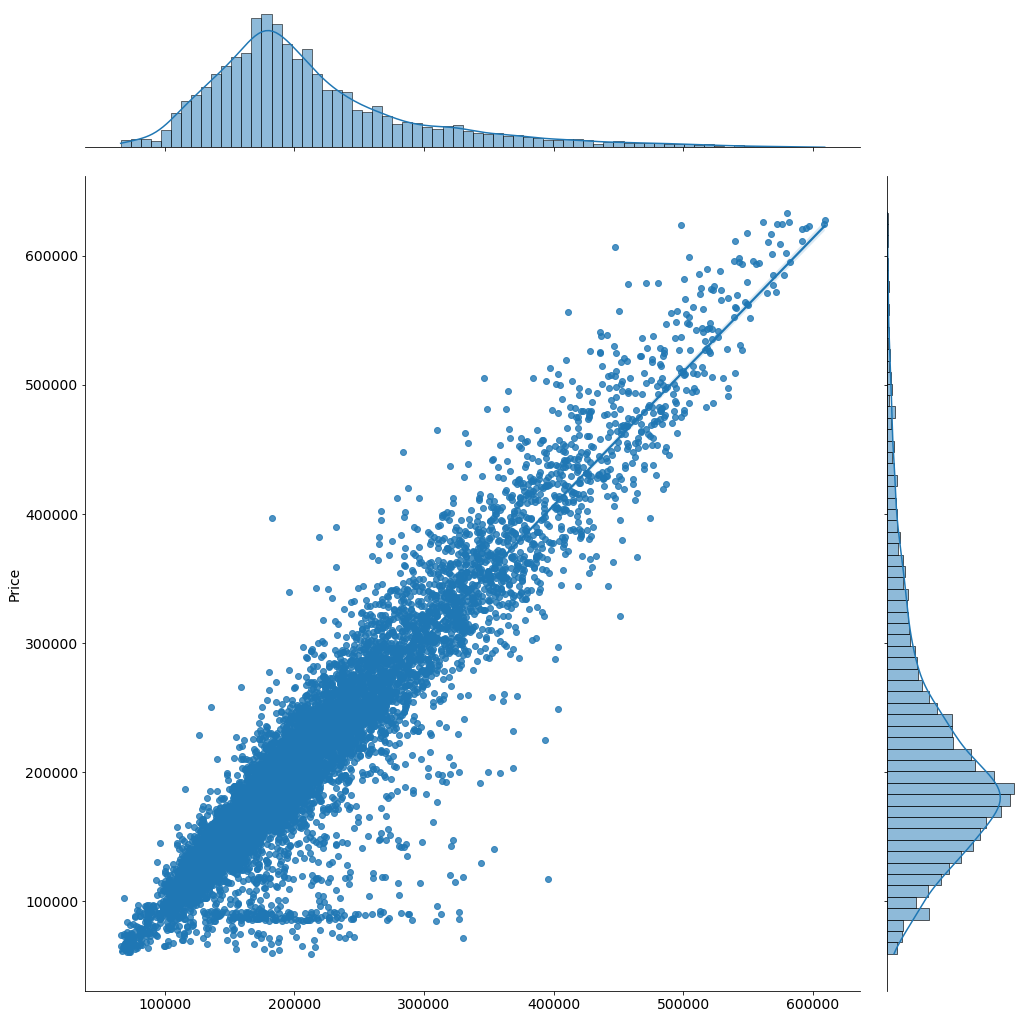

In [1169]:
# Предсказания:
grid = sns.jointplot(x=model.predict(X_train), y=y_train, kind='reg', height=8)
grid.fig.set_figwidth(15)
grid.fig.set_figheight(15)
plt.show()

В целом довольно кучно, но есть вытянутое пятно на уровне цены в 80.000 - тут есть какая-то неучтенная зависимость. Посмотрим, какие именно признаки модель сочла значимыми:

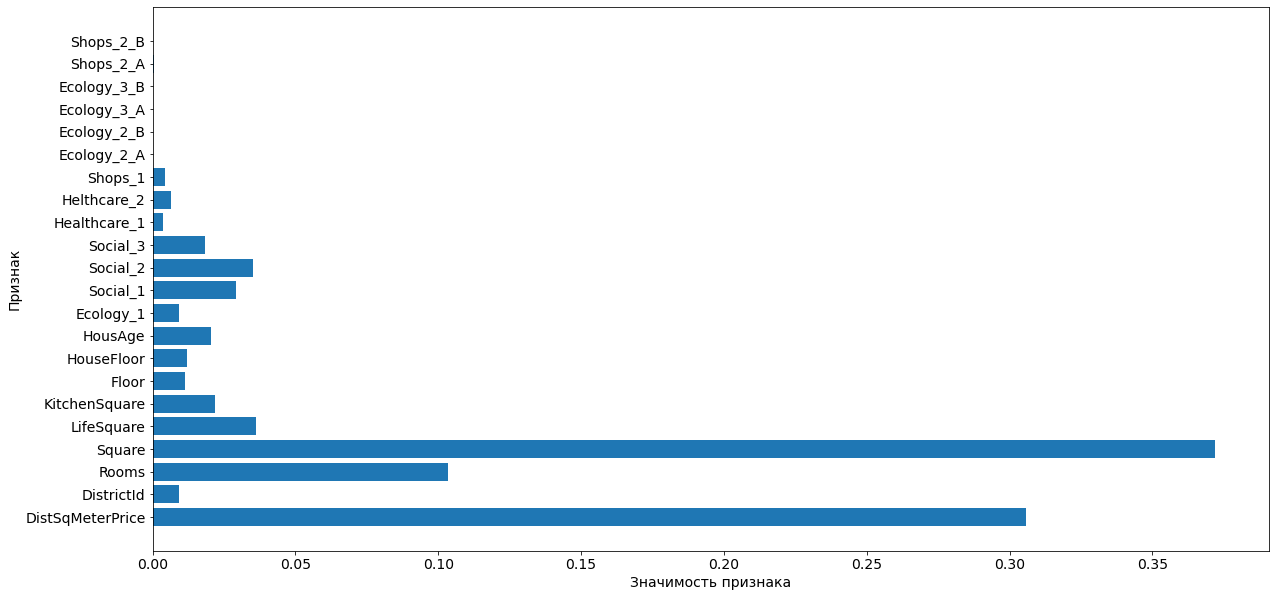

In [1170]:
plt.figure(figsize=(20,10))
plt.barh(X_train.columns.tolist(), model.feature_importances_)
plt.xlabel('Значимость признака')
plt.ylabel('Признак')
plt.show()

### 5. Выгрузка результата

In [1171]:
result=pd.DataFrame({'Id':test_idx, 'Price':pred})
result.sample(frac=1)

,Id,Price
1670,13693,207162.660247
2658,626,205086.486994
3542,3878,191465.310023
4917,13197,207512.716878
3416,9553,160383.459377
...,...,...
2559,11336,75457.396233
4123,16085,185779.669602
2836,12038,238496.737285
3957,9844,166906.425469


In [1172]:
result.to_csv(RESULT_PATH, index=False, encoding='utf-8', sep=',')

In [1173]:
pip freeze

aiohttp @ file:///C:/ci/aiohttp_1646806572557/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.2.0
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1650634291321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-timeout @ file:///tmp/build/80754af9/async-timeout_1637851218186/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/8075